# Machine learning in feature Hilbert space

In [1]:
# the version of Yao is 0.4.1 in this notebook
using Yao, Yao.ConstGate
using Plots
using QuAlgorithmZoo: random_diff_circuit, pair_ring
using Random
using Flux: ADAM, Optimise

## Dataset

In [2]:
y(x, y) = Int((2x^2 + y^2) < π)

y (generic function with 1 method)

In [3]:
function generate_train_batch(nbatch::Int)
    xs = rand(nbatch,2)*2π
    xs, y.(xs[:,1], xs[:,2])
end

generate_train_batch (generic function with 1 method)

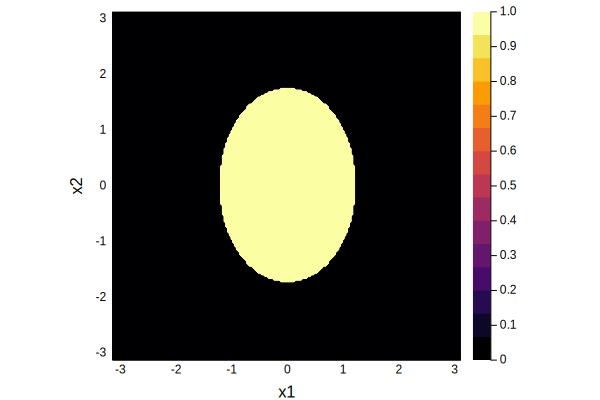

In [4]:
a = -π:0.01π:π
b = -π:0.01π:π
plot(a, b, y, st = :contourf, aspect_ratio=:equal, xlabel="x1", ylabel="x2")

## Model

![_differentiable.png](images/differentiable.png)

In [5]:
nbit = 4
circuit = random_diff_circuit(nbit, 2, pair_ring(nbit));

In [29]:
# pick two parameters
rots = collect_blocks(RotationGate, circuit);
tworots = rots[[10,13]]

In [9]:
"""
Construct a swap test circuit.
"""
function swap_test(nbits::Int, nstate::Int)
    N = nstate*nbits + 1
    chain(N, put(N, 1=>H),
    chain(N, [chain(N, [control(N, 1, (i+(k*nbits-nbits)+1, i+k*nbits+1)=>SWAP)
    for i=1:nbits]) for k=1:nstate-1]),
    put(N, 1=>H)
)
end

swap_test

In [10]:
"""
calculate the (squared) overlap of two states |<ψ|ψ'>|^2
"""
function state_overlap(reg1::AbstractRegister, reg2::AbstractRegister)
    nbits = nactive(reg1)
    @assert nactive(reg2) == nbits error("Register size mismatch!")
    circuit = swap_test(nbits, 2)
    reg_ancilla = join(reg1, reg2, zero_state(1))
    reg_ancilla |> circuit
    expect(put(2nbits+1, 1=>Z), reg_ancilla) |> real
end

state_overlap

In [11]:
"""
A point in RKHS ψ0 defines a function, f(x) = K(x0,x) = <ψ0, Φ(x)>
"""
function Kf!(circuit::AbstractBlock, rots, x, ψ0::AbstractRegister)
    nbit = nqubits(circuit)
    dispatch!.(rots, x)
    ψ = zero_state(nbit) |> circuit
    state_overlap(ψ, ψ0)
end

Kf

## Loss Function

In [12]:
function batched_loss(circuit, rots, xs0, train_batch)
    xs, ys = train_batch
    dispatch!.(rots, xs0)
    loss = 0
    ψ0 = zero_state(nqubits(circuit)) |> circuit
    for (x1, x2, yt) in zip(view(xs, :, 1), view(xs, :, 2), ys)
        loss += abs(Kf!(circuit, rots, (x1, x2), ψ0) - yt)
    end
    loss/length(xs)
end

batched_loss (generic function with 1 method)

In [13]:
function miss_rate(circuit, rots, xs0, train_batch)
    xs, ys = train_batch
    dispatch!.(rots, xs0)
    loss = 0
    ψ0 = zero_state(nqubits(circuit)) |> circuit
    for (x1, x2, yt) in zip(view(xs, :, 1), view(xs, :, 2), ys)
        loss += abs(round(Kf(circuit, rots, (x1, x2), ψ0)) - yt)
    end
    loss/length(xs)
end

miss_rate (generic function with 1 method)

## Training

Check the gradients

In [14]:
Random.seed!(6)
dispatch!(circuit, :random)
x0 = randn(2)
tset = generate_train_batch(100)
x1 = copy(x0); x1[2]+=1e-5
loss0 = batched_loss(circuit, tworots, x0, tset)
loss1 = batched_loss(circuit, tworots, x1, tset)
(loss1-loss0)/1e-5

0.0046946734610919805

In [15]:
function circuit_gradient(circuit, tworots, x0, tset)
    grad = zeros(2)
    for i=1:length(x0)
        x0[i]-=π/2
        loss0 = batched_loss(circuit, tworots, x0, tset)
        x0[i]+=π
        loss1 = batched_loss(circuit, tworots, x0, tset)
        grad[i] = (loss1-loss0)/2
        x0[i]-=π/2
    end
    grad
end

circuit_gradient (generic function with 1 method)

In [16]:
circuit_gradient(circuit, tworots, x0, tset)

2-element Array{Float64,1}:
 0.0012795498085420576
 0.004694527012587338 

In [17]:
function train!(circuit, tworots; maxiter::Int=100, lr::Float64=0.1, nbatch::Int=100)
    optimizer = ADAM(lr)
    x0 = rand(2)*2π
    loss_history = Float64[]
    for i=1:maxiter
        tset = generate_train_batch(nbatch)
        grad = circuit_gradient(circuit, tworots, x0, tset)
        Optimise.update!(optimizer, x0, grad)
        push!(loss_history, batched_loss(circuit, tworots, x0, tset))
        @show loss_history[end]
    end
    x0, loss_history
end

train! (generic function with 1 method)

┌ Info: Recompiling stale cache file /home/leo/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


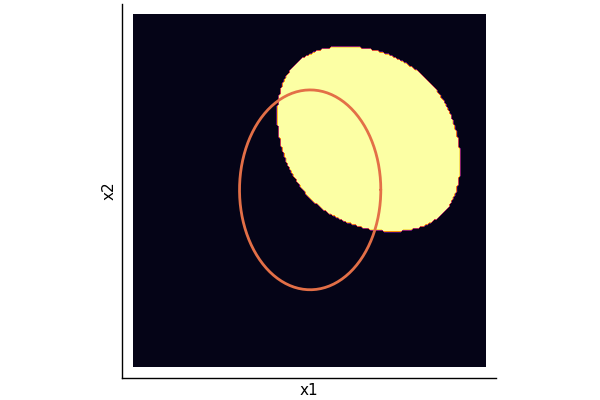

In [18]:
pyplot(leg=false, ticks=nothing)
dispatch!.(tworots, x0)
ψ0 = zero_state(nqubits(circuit)) |> circuit
p = plot(a, b, (x,y)->Kf(circuit, tworots, (x, y), ψ0)>0.5, st = :contourf, aspect_ratio=:equal, xlabel="x1", ylabel="x2")
t = LinRange(0,2π,200)
xs = sqrt(π)*cos.(t)/sqrt(2)
ys = sqrt(π)*sin.(t)
plot!(p[1], xs, ys, lw=2)

In [19]:
xopt, history = train!(circuit, tworots; lr=0.1, nbatch=500)

loss_history[end] = 0.1527873276767025
loss_history[end] = 0.14577666160154965
loss_history[end] = 0.13765783961619085
loss_history[end] = 0.1555743213327508
loss_history[end] = 0.13774992863810614
loss_history[end] = 0.13673670906941005
loss_history[end] = 0.1273143734319433
loss_history[end] = 0.14103512242153257
loss_history[end] = 0.13459670288387596
loss_history[end] = 0.11606189863138587
loss_history[end] = 0.12725777727187
loss_history[end] = 0.13371524981064653
loss_history[end] = 0.129255181899722
loss_history[end] = 0.12898999531320568
loss_history[end] = 0.12292790493448978
loss_history[end] = 0.10904440664945615
loss_history[end] = 0.11279601632047412
loss_history[end] = 0.11928696931329043
loss_history[end] = 0.11873961757622928
loss_history[end] = 0.11451399661112494
loss_history[end] = 0.1219634828301626
loss_history[end] = 0.11791105209400968
loss_history[end] = 0.11053138126944997
loss_history[end] = 0.12012149754340923
loss_history[end] = 0.11273941937236977
loss_hist

([6.68206, 7.03959], [0.152787, 0.145777, 0.137658, 0.155574, 0.13775, 0.136737, 0.127314, 0.141035, 0.134597, 0.116062  …  0.110441, 0.112461, 0.118319, 0.118969, 0.108006, 0.113191, 0.108607, 0.126128, 0.125366, 0.120565])

In [20]:
dispatch!.(tworots, xopt)
ψ0 = zero_state(nqubits(circuit)) |> circuit

ArrayReg{1, Complex{Float64}, Array...}
    active qubits: 4/4

In [21]:
miss_rate(circuit, tworots, x0, generate_train_batch(1000))

0.086

In [22]:
miss_rate(circuit, tworots, xopt, generate_train_batch(1000))

0.075

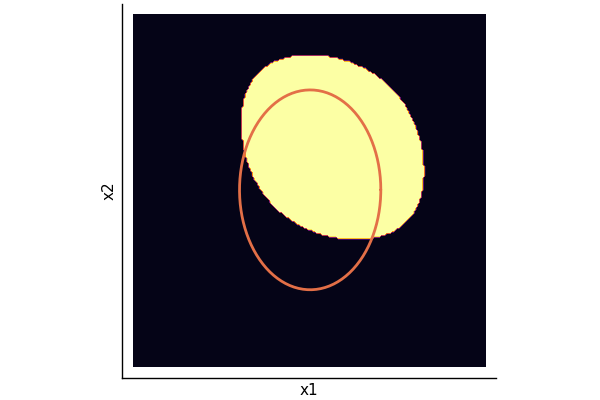

In [23]:
pyplot(leg=false, ticks=nothing)
dispatch!.(tworots, xopt)
ψ0 = zero_state(nqubits(circuit)) |> circuit
p = plot(a, b, (x,y)->Kf(circuit, tworots, (x, y), ψ0)>0.5, st = :contourf, aspect_ratio=:equal, xlabel="x1", ylabel="x2")
#plot!(p[2], a, b, y, st = :contourf, aspect_ratio=:equal, xlabel="x1", ylabel="x2")
t = LinRange(0,2π,200)
xs = sqrt(π)*cos.(t)/sqrt(2)
ys = sqrt(π)*sin.(t)
plot!(p[1], xs, ys, lw=2)

## See someone devloping codes

In [30]:
"""
 QuantumKernelMachine

warning: don't use abstract type like this when designing structures used inside a loop
"""
struct QuantumKernelMachine
    x_rots::Vector
    w_rots::Vector
    x_params::Vector
    w_params::Vector
    
    circuit::AbstractBlock
    function QuantumKernelMachine(circuit, x_locs)
        rots = collect(RotationGate, circuit)
        x_rots = rots[x_locs]
        w_rots = setdiff(rots)
        new(x_rots, w_rots, x_params, w_params, circuit)
    end
end

LoadError: syntax: incomplete: "struct" at none:6 requires end